###Импорт необходимых модулей и функций

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from algorithms_pca.linear_solver import gauss_solver
from algorithms_pca.statistics import covariance_matrix
from algorithms_pca.eigen import find_eigenvalues, find_eigenvectors
from algorithms_pca.visualization import plot_pca_projection
from algorithms_pca.utils import apply_pca_to_dataset, add_noise_and_compare
from numpy.linalg import eigh
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as SklearnPCA
from algorithms_pca.matrix import Matrix
from algorithms_pca.pca import pca_qr
from algorithms_pca.statistics import center_data
from algorithms_pca.utils import auto_select_k

###Базовые операции над матрицами


Создаем две матрицы A и B размера 2×2 и демонстрируем различные операции

In [8]:
A = Matrix([[4, 7], [2, 6]])  # пример матрицы A
B = Matrix([[3, 8], [5, 1]])  # пример матрицы B
print("A + B =", A + B)          # сложение поэлементно
print("A - B =", A - B)          # вычитание
print("A * B (elem) =", A * B)   # поэлементное умножение
print("A.matmul(B) =", A.matmul(B))  # матричное умножение
print("A.T =", A.T)              # транспонирование
print("det(A) =", A.determinant())   # определитель
print("inv(A) =", A.inverse())      # обратная матрица
print("rank(A) =", A.rank())        # ранг
print("trace(A) =", A.trace())      # след
P, L, U = A.lu()                   # LU-разложение
print("P, L, U =", P, L, U)
# Решение Ax = b методом LU
x = A.solve(Matrix([[1], [0]]))
print("Solution x to Ax=b =", x)
# Решение той же системы методом Гаусса
x = gauss_solver(A, Matrix([[1], [0]]))
print("Solution x to Ax=b =", x)

A + B = Matrix([[7, 15], [7, 7]])
A - B = Matrix([[1, -1], [-3, 5]])
A * B (elem) = Matrix([[12, 56], [10, 6]])
A.matmul(B) = Matrix([[47.0, 39.0], [36.0, 22.0]])
A.T = Matrix([[4, 2], [7, 6]])
det(A) = 10.0
inv(A) = Matrix([[0.6000000000000001, -0.7000000000000001], [-0.2, 0.4]])
rank(A) = 2
trace(A) = 10
P, L, U = Matrix([[1.0, 0.0], [0.0, 1.0]]) Matrix([[1.0, 0.0], [0.5, 1.0]]) Matrix([[4, 7], [0.0, 2.5]])
Solution x to Ax=b = Matrix([[0.6000000000000001], [-0.2]])
Solution x to Ax=b = [Matrix([[0.6000000000000001], [-0.2]])]


Новый пример решения квадратной системы методом LU и Гаусса

In [9]:
A = Matrix([[1, 2, 3], [4, 5, 6], [7, 8, 10]])
x = A.solve(Matrix([[6], [15], [25]]))
print("Solution x to Ax=b =", x)

x = gauss_solver(A, Matrix([[6], [15], [25]]))
print("Solution x to Ax=b =", x)

Solution x to Ax=b = Matrix([[-6.142857142857159], [47.42857142857147], [-31.142857142857167]])
Solution x to Ax=b = [Matrix([[1.0000000000000013], [0.9999999999999969], [1.0000000000000016]])]


Решаем систему, где матрица вырождена и есть свободные переменные

In [10]:
A = Matrix([
    [1, 2, -1],
    [-2, -4, 2],
    [3, 6, -3]
])
b = Matrix([
    [1],
    [-2],
    [3]
])
solutions = gauss_solver(A, b)  # система имеет бесконечно много решений
print(solutions)

[Matrix([[1.0], [0.0], [0.0]]), Matrix([[-2.0], [1.0], [0.0]]), Matrix([[1.0], [0.0], [1.0]])]


###Cтатистика – центрирование и ковариация

Пример центрирования данных и расчета ковариационной матрицы

In [11]:
X = Matrix([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])
X_centered, _ = center_data(X)  # вычитание среднего по столбцам
print("Центрированная матрица:")
print(X_centered)
cov = covariance_matrix(X_centered)  # ковариационная матрица
print("Матрица ковариаций:")
print(cov)

Центрированная матрица:
Matrix([[-3.0, -3.0, -3.0], [0.0, 0.0, 0.0], [3.0, 3.0, 3.0]])
Матрица ковариаций:
Matrix([[9.0, 9.0, 9.0], [9.0, 9.0, 9.0], [9.0, 9.0, 9.0]])


###PCA простым методом и визуализация

Демонстрация применения PCA к небольшому набору данных и построение графика

Projected data (n×k): Matrix([[-2.507607754987199, 0.05132281090050961], [-2.5593412408261225, -0.11859180693717364], [2.1310551995386993, -0.2517599467126616], [1.5869484075332654, -0.2884740780355951], [1.3489453887413576, 0.6075030207849226]])
Explained variance ratio: 0.9875


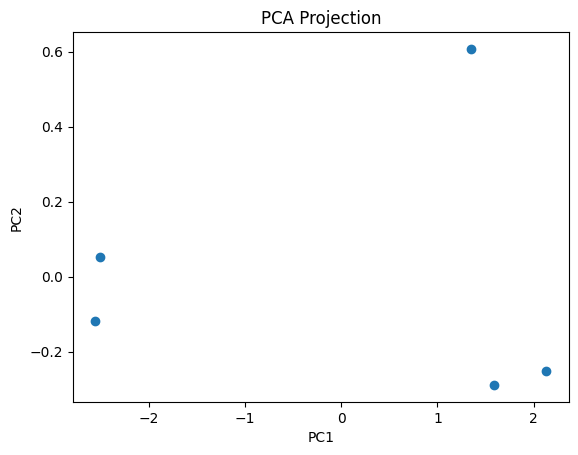

In [12]:
sample_data = Matrix([
    [5.1, 3.5, 1.4, 0.2],
    [4.9, 3.0, 1.4, 0.2],
    [6.2, 3.4, 5.4, 2.3],
    [5.9, 3.0, 5.1, 1.8],
    [6.7, 3.1, 4.7, 1.5],
])
X_proj_qr, ratio_qr, raw_vals, W, means = pca_qr(sample_data, k=2)
print(f"Projected data (n×k): {X_proj_qr}")
print(f"Explained variance ratio: {ratio_qr:.4f}")
fig = plot_pca_projection(X_proj_qr)

Cравнение с numpy и sklearn. Повторяем PCA с использованием numpy, сверяем результаты

In [13]:
mean = np.mean(sample_data._data, axis=0)
X_centered_np = np.array(sample_data._data) - mean
cov_matrix = np.cov(X_centered_np, rowvar=False)
eig_vals, eig_vecs = eigh(cov_matrix)
sorted_idx = np.argsort(eig_vals)[::-1]
eig_vecs_sorted = eig_vecs[:, sorted_idx]
eig_vals_sorted = eig_vals[sorted_idx]
k = 1
components = eig_vecs_sorted[:, :k]
X_p_np = X_centered_np @ components
explained_np = eig_vals_sorted[:k].sum() / eig_vals_sorted.sum()
print("Projected data (n×k):")
print(X_p_np)
print(f"Explained variance ratio: {explained_np:.4f}")

Projected data (n×k):
[[ 2.50760775]
 [ 2.55934124]
 [-2.1310552 ]
 [-1.58694841]
 [-1.34894539]]
Explained variance ratio: 0.9639


###Автоподбор числа компонент k по порогу

Автоматический выбор k на основе порога объясненной дисперсии

In [14]:
X = Matrix([
    [2.5, 2.4, 1.2, 3.1, 0.5],
    [0.5, 0.7, 1.5, 2.9, 0.3],
    [2.2, 2.9, 0.9, 3.2, 0.6],
    [1.9, 2.2, 1.0, 3.0, 0.4],
    [3.1, 3.0, 1.3, 3.5, 0.7],
    [2.3, 2.7, 1.1, 3.3, 0.5]
])
eig = find_eigenvalues(covariance_matrix(center_data(X)[0]))
k_selected = auto_select_k(eig, 0.95)
print(f"Автоподобранное k (95%): {k_selected}")

Автоподобранное k (95%): 2


Добавление шума и сравнение восстановления, применяем функцию add_noise_and_compare и смотрим на метрики

In [15]:
X_example = Matrix([
    [2.5, 2.4, 1.2, 3.1, 0.5],
    [0.5, 0.7, 1.5, 2.9, 0.3],
    [2.2, 2.9, 0.9, 3.2, 0.6],
    [1.9, 2.2, 1.0, 3.0, 0.4],
    [3.1, 3.0, 1.3, 3.5, 0.7],
    [2.3, 2.7, 1.1, 3.3, 0.5]
])
result = add_noise_and_compare(X_example, noise_level=0.2)
print("Selected k:", result['k'])
print("Explained ratio (orig):", result['ratio_orig'])
print("Explained ratio (noisy):", result['ratio_noisy'])

Selected k: 2
Explained ratio (orig): 0.9867781313706439
Explained ratio (noisy): 0.9674327900697505


Применение PCA к датасету Iris и сравнение алгоритмов


In [16]:
X_proj_iris, ratio_iris = apply_pca_to_dataset('iris', 1)
print(f"Iris dataset projected shape: ({X_proj_iris.rows}, {X_proj_iris.cols})")
print(f"Explained ratio (iris, k=1): {ratio_iris:.4f}")

Iris dataset projected shape: (150, 1)
Explained ratio (iris, k=1): 0.9246


Пример: вычисление собственных значений и векторов для небольшой матрицы

In [17]:
# Создаём 2×2 матрицу
data = Matrix([
    [-1, -6],
    [2, 6]
])

# Вычисляем собственные значения (λ) методом бисекции по характеристическому многочлену
eigenvalues = find_eigenvalues(data)

# Для каждого найденного собственного значения находим собственный вектор решениями (C - λI)x = 0
eigenvectors = find_eigenvectors(data, eigenvalues)

# Выводим результат
print("\nСобственные значения:", [f"{λ:.3f}" for λ in eigenvalues])  # округляем до 3 знаков
print("\nСобственные векторы:")
for i, vec in enumerate(eigenvectors, start=1):
    print(f"Вектор {i}:", vec)  # каждый vec — это объект Matrix-столбец


Собственные значения: ['2.000', '3.000']

Собственные векторы:
Вектор 1: [Matrix([[-2.0], [1.0]])]
Вектор 2: [Matrix([[-1.5], [1.0]])]


###Сравнение собственного QR-PCA с реализацией sklearn на датасете Iris

Выбранное k = 2
PCA_QR explained variance ratio = 0.9777
sklearn explained variance ratio = 0.9581


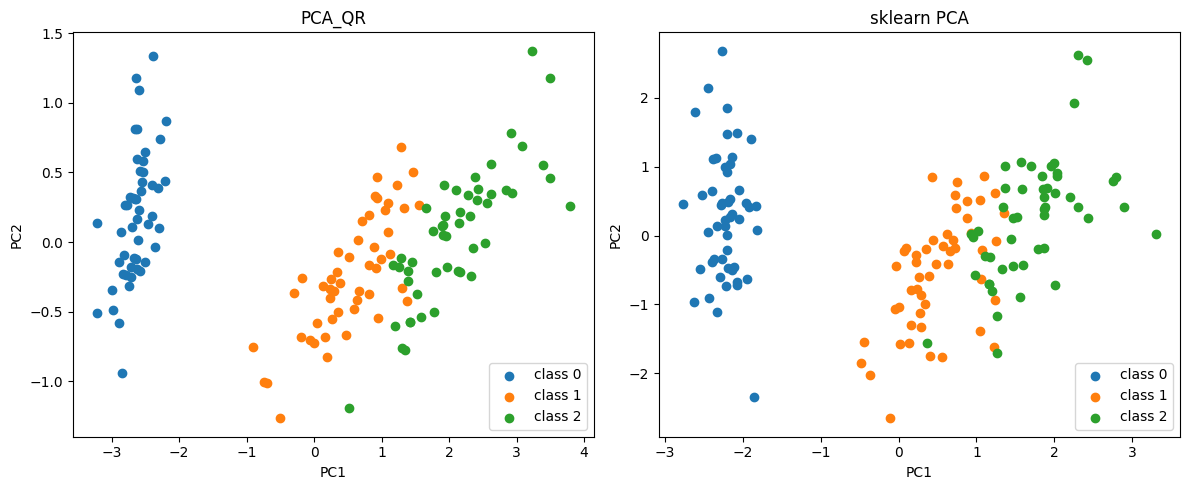

Accuracy PCA_QR + LogisticRegression = 0.9778
Accuracy sklearn PCA + LogisticRegression = 0.8667


In [18]:
def matrix_to_np(X: Matrix) -> np.ndarray:
    """Конвертация объекта Matrix в numpy.ndarray для sklearn и визуализации."""
    return np.array(X._data)


def visualize(X_my: np.ndarray, X_sk: np.ndarray, y: np.ndarray):
    """
    Строит две диаграммы рассеяния:
    - слева — собственная реализация PCA_QR,
    - справа — sklearn PCA,
    с раскраской точек по классам.
    """
    plt.figure(figsize=(12, 5))
    for i, (Xp, title) in enumerate([(X_my, "PCA_QR"), (X_sk, "sklearn PCA")], start=1):
        ax = plt.subplot(1, 2, i)
        for cls in np.unique(y):
            ax.scatter(Xp[y == cls, 0], Xp[y == cls, 1], label=f"class {cls}")
        ax.set_title(title)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.legend()
    plt.tight_layout()
    plt.show()


# 1. Загрузка данных Iris и преобразование в Matrix
data = load_iris()
X_np = data.data          # numpy array размером (150,4)
y = data.target           # метки классов
X = Matrix(X_np.tolist()) # переводим в наш Matrix

# 2. Стандартизация признаков для sklearn PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

# 3. Автоподбор числа компонент k по порогу объяснённой дисперсии (95%) через QR-PCA
Xc, _ = center_data(X)           # центрируем данные
Cov = Xc.T.matmul(Xc)  / X.rows         # ковариационная матрица
eigvals = Cov.qr_eigen()[0]      # находим все собственные значения через QR-алгоритм
k = auto_select_k(eigvals, 0.95) # выбираем минимальное k, дающее не менее 95% дисперсии
print("Выбранное k =", k)

# 4. Собственная реализация PCA через QR-алгоритм
X_proj_qr, ratio_qr, raw_vals, W, means = pca_qr(X, k)
Xp_qr_np = matrix_to_np(X_proj_qr)
print(f"PCA_QR explained variance ratio = {ratio_qr:.4f}")

# 5. PCA от sklearn для сравнения
sk_pca = SklearnPCA(n_components=k)
Xp_sk = sk_pca.fit_transform(X_scaled)
print(f"sklearn explained variance ratio = {sk_pca.explained_variance_ratio_.sum():.4f}")

# 6. Визуализация проекций двух методов
visualize(Xp_qr_np, Xp_sk, y)

# 7. Классификация на новых признаках и оценка качества
#   разбиваем данные на train/test
X_tr_qr, X_te_qr, y_tr, y_te = train_test_split(
    Xp_qr_np, y, test_size=0.3, random_state=0
)
X_tr_sk, X_te_sk, _, _ = train_test_split(
    Xp_sk, y, test_size=0.3, random_state=0
)

# обучаем логистическую регрессию на проекциях
clf_qr = LogisticRegression(max_iter=1000).fit(X_tr_qr, y_tr)
clf_sk = LogisticRegression(max_iter=1000).fit(X_tr_sk, y_tr)

# вычисляем точность (accuracy) на тесте
acc_qr = accuracy_score(y_te, clf_qr.predict(X_te_qr))
acc_sk = accuracy_score(y_te, clf_sk.predict(X_te_sk))
print(f"Accuracy PCA_QR + LogisticRegression = {acc_qr:.4f}")
print(f"Accuracy sklearn PCA + LogisticRegression = {acc_sk:.4f}")

# Математическое обоснование PCA

**Цель:** Доказать, что оптимальные направления PCA, максимизирующие дисперсию проекции данных, совпадают с собственными векторами матрицы ковариаций $\Sigma$, соответствующими наибольшим собственным значениям.

---

### Шаг 1: Определение дисперсии проекции

- Цель PCA — найти направление $u$, которое максимизирует дисперсию спроецированных данных $p = X_c u$.
- Дисперсия проекции:

  $$
  \text{Var}(p) = \frac{1}{n-1} \sum_{i=1}^n p_i^2 = \frac{1}{n-1} \|p\|^2
  $$

- Подставим $p = X_c u$:

  $$
  \text{Var}(p) = \frac{1}{n-1} \|X_c u\|^2 = \frac{1}{n-1} (X_c u)^T (X_c u) = \frac{1}{n-1} u^T X_c^T X_c u
  $$

---

### Шаг 2: Связь дисперсии с матрицей ковариаций

- Определим матрицу ковариаций:

  $$
  \Sigma = \frac{1}{n-1} X_c^T X_c
  $$

- Тогда дисперсия:

  $$
  \text{Var}(p) = u^T \Sigma u
  $$

- То есть максимизация дисперсии эквивалентна максимизации $u^T \Sigma u$.

---

### Шаг 3: Формулировка оптимизационной задачи

- Найти вектор $u$, который решает задачу:

  $$
  \max_{u} \quad u^T \Sigma u \quad \text{при условии} \quad u^T u = 1
  $$

---

### Шаг 4: Спектральная теорема

- Матрица $\Sigma$ — вещественная и симметричная.
- По спектральной теореме, существует ортонормированный базис из собственных векторов $v_1, v_2, \dots, v_m$.
- Им соответствуют собственные значения $\lambda_1 \ge \lambda_2 \ge \dots \ge \lambda_m \ge 0$:

  $$
  \Sigma v_i = \lambda_i v_i, \quad v_i^T v_j = \delta_{ij}
  $$

---

### Шаг 5: Разложение $u$ по базису собственных векторов

- Разложим вектор $u$:

  $$
  u = \sum_{i=1}^m c_i v_i, \quad \sum_{i=1}^m c_i^2 = 1
  $$

- Тогда:

  $$
  u^T \Sigma u = \sum_{i=1}^m c_i^2 \lambda_i
  $$

---

### Шаг 6: Максимизация выражения

- Оптимизация:

  $$
  \max \sum_{i=1}^m c_i^2 \lambda_i \quad \text{при} \quad \sum_{i=1}^m c_i^2 = 1
  $$

- Максимум достигается при $c_1 = \pm 1$, остальные $c_i = 0$, если $\lambda_1 > \lambda_2$.
- Тогда:

  $$
  u = \pm v_1
  $$

---

### Шаг 7: Вывод

- Оптимальное направление $u$ совпадает с собственным вектором $v_1$, соответствующим наибольшему собственному значению $\lambda_1$ (с точностью до знака).

**Ч.т.д.**